# 차선 인식 (Lane Detection)

이 노트북에서는 LiDAR 포인트 클라우드를 활용하여 차선을 검출하는 방법을 학습합니다.

## 학습 목표

- LiDAR 기반 차선 인식의 원리 이해
- 반사율(Intensity) 정보를 활용한 차선 검출
- 바닥면 투영 및 누적 히스토그램 방법 이해
- 차선 검출 알고리즘 구현
- 곡선 차선 모델링 및 파라미터 추출

## 1. 필요한 라이브러리 설치 및 임포트

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import os
import sys
import cv2
from scipy import ndimage, signal

# 프로젝트 루트 경로 추가
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# 유틸리티 모듈 임포트
from utils.ground_detection import (
    ransac_ground_detection,
    height_threshold_ground_detection,
    extract_ground_points
)

# Matplotlib을 사용한 시각화 함수 (헤드리스 환경에서도 작동)
def visualize_with_matplotlib(points, sample_size=5000):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 점 샘플링 (모든 점을 그리면 너무 많아서 느려짐)
    sample_idx = np.random.choice(points.shape[0], min(sample_size, points.shape[0]), replace=False)
    sampled_points = points[sample_idx]
    
    # 높이(z)에 따라 색상 지정
    scatter = ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2],
                         c=sampled_points[:, 2], cmap='viridis', s=1)
    
    # 축 레이블 설정
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('포인트 클라우드 3D 시각화')
    
    # 컬러바 추가
    plt.colorbar(scatter, ax=ax, label='높이 (m)')
    
    plt.tight_layout()
    return fig

# 시각화 설정
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

## 2. 데이터 로드

KITTI 데이터셋에서 포인트 클라우드를 로드합니다.

In [3]:
def load_point_cloud(bin_path):
    """
    KITTI bin 형식의 포인트 클라우드 파일 로드
    
    Args:
        bin_path (str): bin 파일 경로
        
    Returns:
        numpy.ndarray: 포인트 클라우드 [N, 4] (x, y, z, intensity)
    """
    # 이진 파일에서 4xN float 배열로 읽기
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points

# 데이터 경로 설정
# data_dir = '../../data/kitti'
# data_dir = os.path.join(parent_dir, 'data')
# point_cloud_dir = os.path.join(data_dir, 'velodyne_points')
data_dir = '/home/shbyun/KITTI/ObjectDetection/'
point_cloud_dir = os.path.join(data_dir, 'data_object_velodyne/training', 'velodyne')

# 첫 번째 프레임 로드
frame_id = '000004'
point_cloud_path = os.path.join(point_cloud_dir, f'{frame_id}.bin')

# 포인트 클라우드 로드
if os.path.exists(point_cloud_path):
    points = load_point_cloud(point_cloud_path)
    print(f"포인트 클라우드 로드 완료: {points.shape}")
else:
    # 데이터가 없는 경우 예시 데이터 생성
    print(f"경로에 데이터가 없습니다: {point_cloud_path}")
    print("예시 데이터를 생성합니다...")
    
    # 예시 데이터 생성 (간단한 지면과 차선)
    x = np.random.uniform(-30, 30, 20000)
    y = np.random.uniform(-30, 30, 20000)
    
    # 지면 생성 (약간 경사진 평면)
    ground_z = -0.1 * x + 0.05 * y - 1.8 + np.random.normal(0, 0.05, 20000)
    
    # 일부 포인트를 객체로 만들기
    object_indices = np.random.choice(20000, 4000, replace=False)
    object_heights = np.random.uniform(0.5, 3.0, 4000)
    
    z = ground_z.copy()
    z[object_indices] += object_heights
    
    # 강도 값 생성 (대부분 낮은 값)
    intensity = np.random.uniform(0, 0.3, 20000)
    
    # 차선 포인트 생성
    # 왼쪽 차선
    left_lane_x = np.linspace(-20, 20, 200)
    left_lane_y = -3 + 0.05 * left_lane_x**2 + np.random.normal(0, 0.1, 200)
    left_lane_z = np.zeros(200)
    
    # 오른쪽 차선
    right_lane_x = np.linspace(-20, 20, 200)
    right_lane_y = 3 + 0.05 * right_lane_x**2 + np.random.normal(0, 0.1, 200)
    right_lane_z = np.zeros(200)
    
    # 각 차선 포인트 주변에 추가 포인트 생성
    def generate_lane_points(lane_x, lane_y, lane_z, width=0.2, num_points=1000):
        indices = np.random.choice(len(lane_x), num_points, replace=True)
        selected_x = lane_x[indices]
        selected_y = lane_y[indices]
        selected_z = lane_z[indices]
        
        # 차선 폭을 고려한 무작위 오프셋 추가
        offset_x = np.random.uniform(-width, width, num_points)
        offset_y = np.random.uniform(-width, width, num_points)
        
        return np.column_stack([
            selected_x + offset_x,
            selected_y + offset_y,
            selected_z - 1.8 + np.random.normal(0, 0.02, num_points)
        ])
    
    left_lane_points = generate_lane_points(left_lane_x, left_lane_y, left_lane_z)
    right_lane_points = generate_lane_points(right_lane_x, right_lane_y, right_lane_z)
    
    # 차선 포인트에 높은 강도값 부여
    left_lane_intensity = np.random.uniform(0.7, 1.0, len(left_lane_points))
    right_lane_intensity = np.random.uniform(0.7, 1.0, len(right_lane_points))
    
    # 기본 포인트 클라우드 생성
    main_points = np.column_stack([x, y, z, intensity])
    
    # 차선 포인트 추가
    left_lane_full = np.column_stack([left_lane_points, left_lane_intensity])
    right_lane_full = np.column_stack([right_lane_points, right_lane_intensity])
    
    # 모든 포인트 합치기
    points = np.vstack([main_points, left_lane_full, right_lane_full])
    
    print(f"예시 데이터 생성 완료: {points.shape}")

# 포인트 클라우드 통계 출력
print(f"포인트 개수: {points.shape[0]}")
print(f"X 범위: [{np.min(points[:, 0]):.2f}, {np.max(points[:, 0]):.2f}]")
print(f"Y 범위: [{np.min(points[:, 1]):.2f}, {np.max(points[:, 1]):.2f}]")
print(f"Z 범위: [{np.min(points[:, 2]):.2f}, {np.max(points[:, 2]):.2f}]")
print(f"강도 범위: [{np.min(points[:, 3]):.2f}, {np.max(points[:, 3]):.2f}]")


포인트 클라우드 로드 완료: (115976, 4)
포인트 개수: 115976
X 범위: [-79.30, 79.03]
Y 범위: [-75.22, 53.15]
Z 범위: [-5.67, 2.90]
강도 범위: [0.00, 0.99]


## 3. 포인트 클라우드 및 강도 시각화

로드한 포인트 클라우드와 강도(intensity) 정보를 시각화합니다.

/tmp/ipykernel_24886/3886527975.py:47: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/3886527975.py:47: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/3886527975.py:47: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/3886527975.py:47: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/3886527975.py:47: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/3886527975.py:47: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/3886527975.py:47: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/3886527975.py:47:

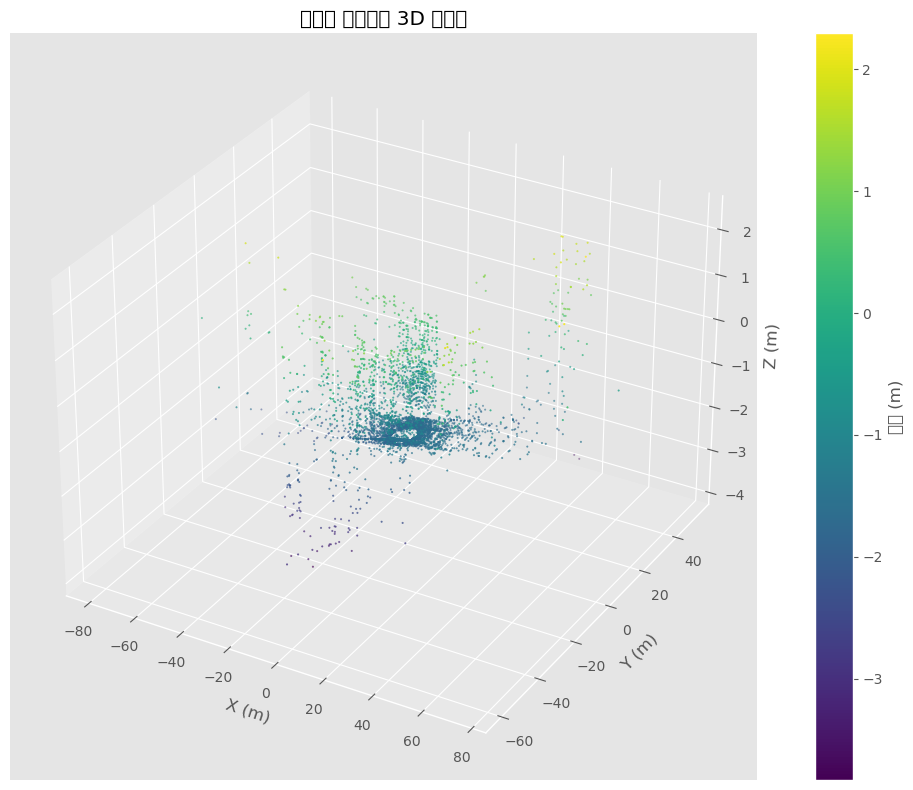

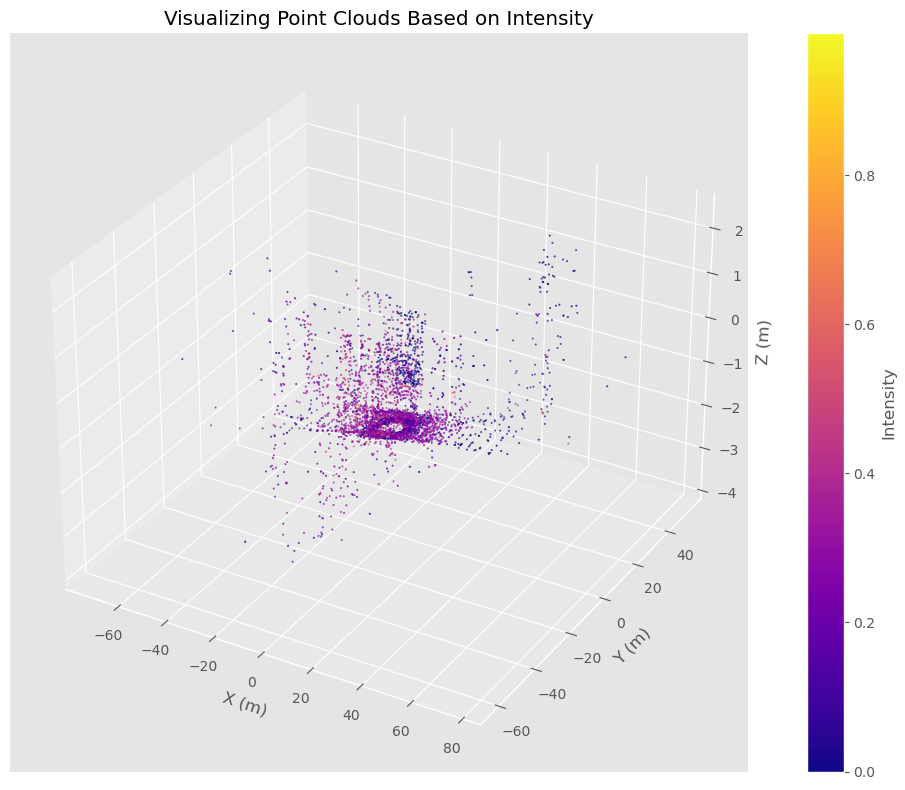

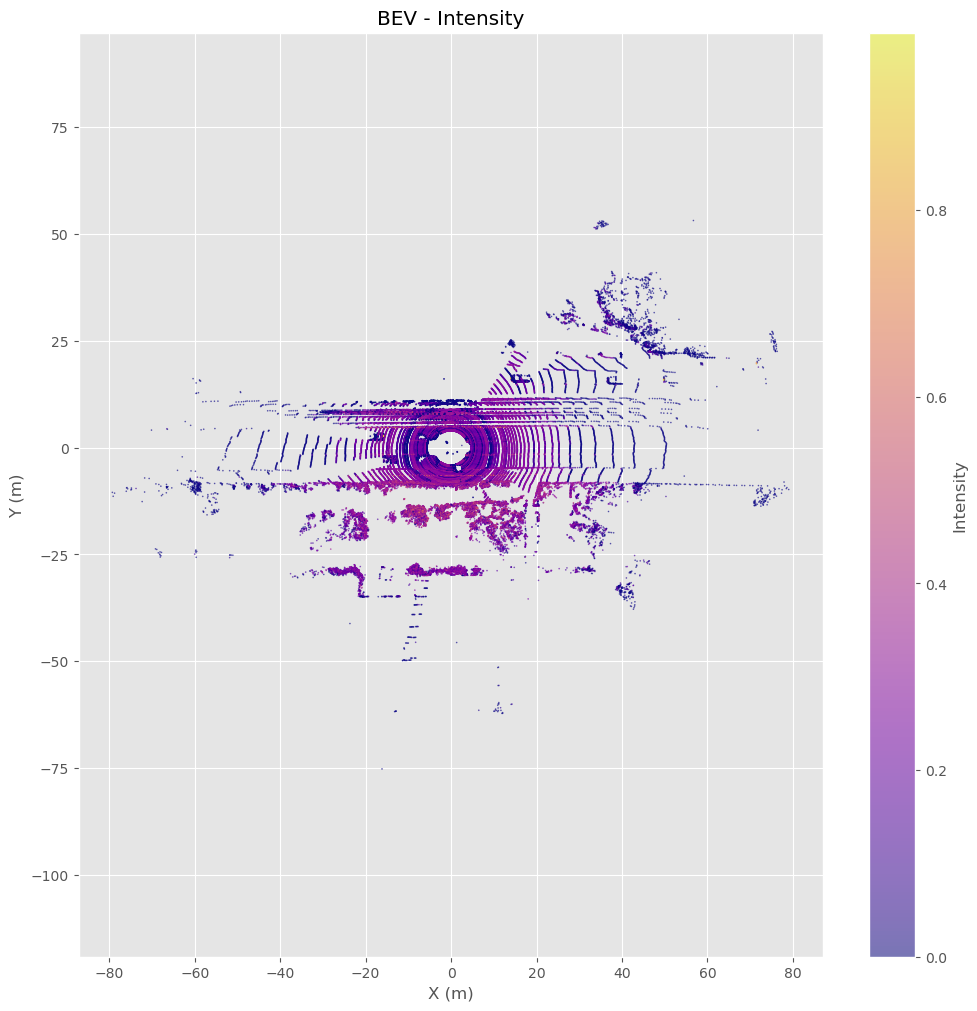

In [13]:
# 3D 포인트 클라우드 시각화
fig_3d = visualize_with_matplotlib(points)
plt.show()

# 강도 기준 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 점 샘플링 (모든 점을 그리면 너무 많아서 느려짐)
sample_idx = np.random.choice(points.shape[0], 5000, replace=False)
sampled_points = points[sample_idx]

# 강도(intensity)에 따라 색상 지정
scatter = ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2],
                     c=sampled_points[:, 3], cmap='plasma', s=1)

# 축 레이블 설정
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Visualizing Point Clouds Based on Intensity')

# 컬러바 추가
plt.colorbar(scatter, ax=ax, label='Intensity')

plt.tight_layout()
plt.show()

# 조감도(BEV) 시각화
plt.figure(figsize=(12, 12))
plt.scatter(points[:, 0], points[:, 1], c=points[:, 3], cmap='plasma', s=0.5, alpha=0.5)
plt.colorbar(label='Intensity')
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('BEV - Intensity')
plt.grid(True)
plt.axis('equal')
plt.show()

## 4. 지면 검출 및 추출

차선은 도로 위에 표시되므로, 먼저 지면을 검출하고 추출합니다.


전체 포인트 개수: 115976
지면 포인트 개수: 67500
지면 포인트 비율: 58.20%
지면 평면 방정식: 0.0076x + -0.0075y + -0.9999z + -1.7196 = 0
추출된 지면 포인트 개수: 67500


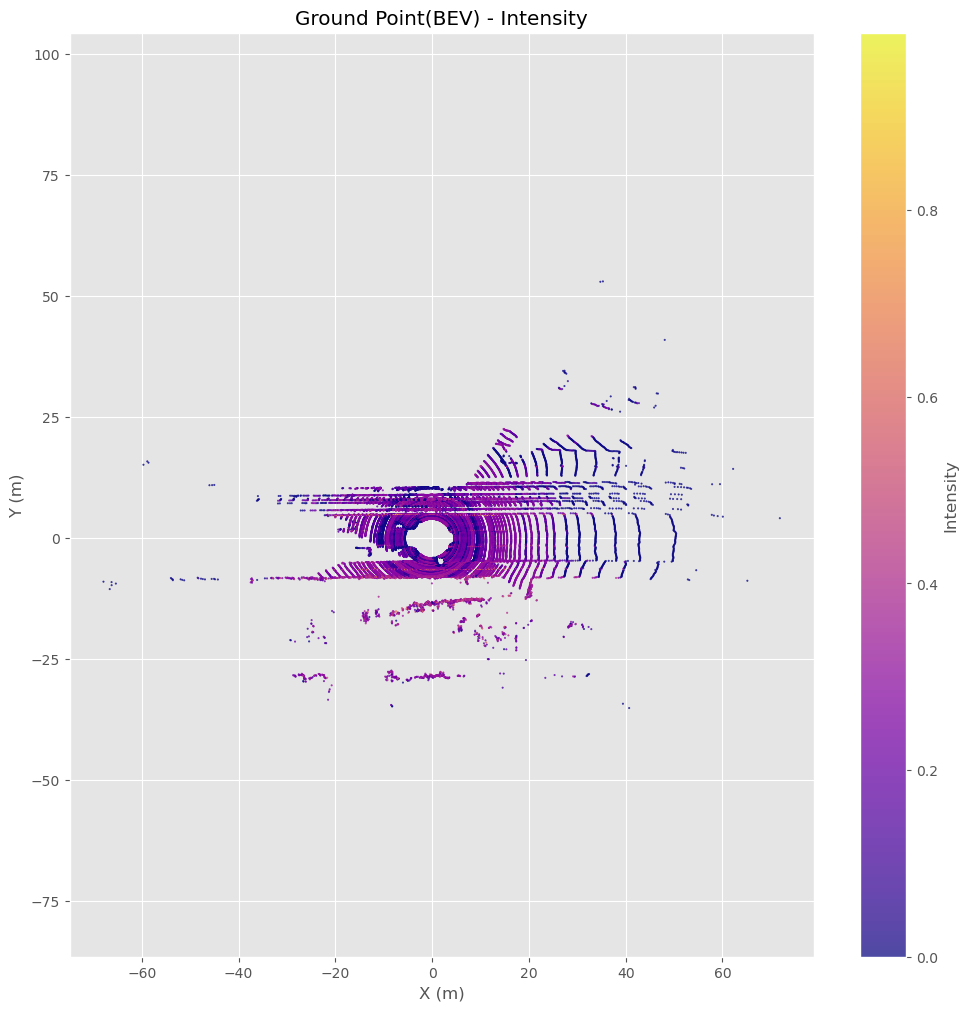

In [14]:
# RANSAC 기반 지면 검출
distance_thresh = 0.15  # 인라이어로 간주하는 평면과의 최대 거리 (m)
max_iterations = 100    # RANSAC 최대 반복 횟수

# 지면 검출
ground_mask, ground_model = ransac_ground_detection(
    points, distance_thresh=distance_thresh, 
    max_iterations=max_iterations, return_model=True
)

# 결과 출력
print(f"전체 포인트 개수: {points.shape[0]}")
print(f"지면 포인트 개수: {np.sum(ground_mask)}")
print(f"지면 포인트 비율: {np.sum(ground_mask) / points.shape[0] * 100:.2f}%")

# 평면 모델 파라미터 출력
normal = ground_model['normal']
intercept = ground_model['intercept']
print(f"지면 평면 방정식: {normal[0]:.4f}x + {normal[1]:.4f}y + {normal[2]:.4f}z + {intercept:.4f} = 0")

# 지면 포인트 추출
ground_points = extract_ground_points(points, ground_mask)
print(f"추출된 지면 포인트 개수: {ground_points.shape[0]}")

# 지면 포인트 시각화
plt.figure(figsize=(12, 12))
plt.scatter(ground_points[:, 0], ground_points[:, 1], c=ground_points[:, 3], 
           cmap='plasma', s=1.0, alpha=0.7)
plt.colorbar(label='Intensity')
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Ground Point(BEV) - Intensity')
plt.grid(True)
plt.axis('equal')
plt.show()

## 5. Intensity 필터링

차선 표시는 대개 높은 반사율을 가지므로, 강도 값이 높은 지면 포인트를 필터링하여 차선 후보를 추출합니다.

높은 강도를 가진 지면 포인트 개수: 629
비율: 0.93%


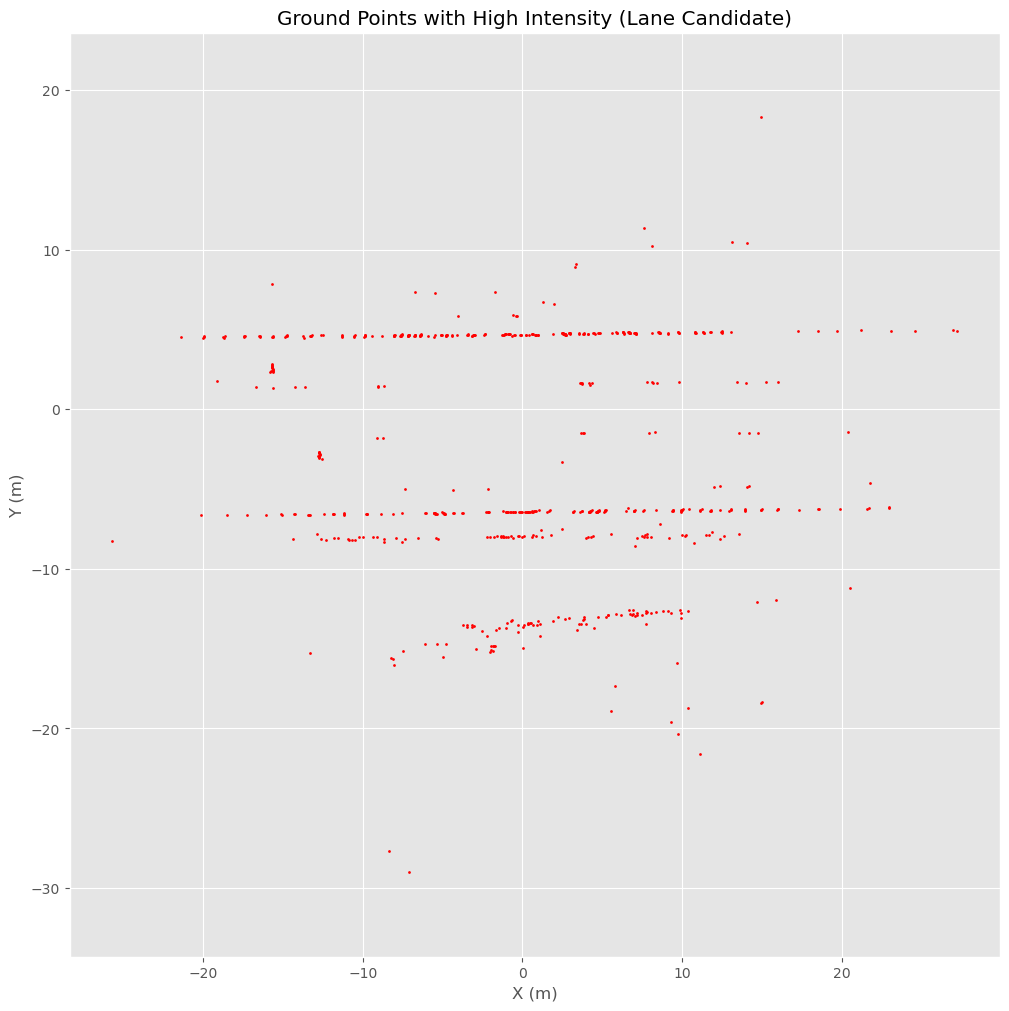

/home/shbyun/miniconda3/envs/lidar-perception/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shbyun/miniconda3/envs/lidar-perception/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shbyun/miniconda3/envs/lidar-perception/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


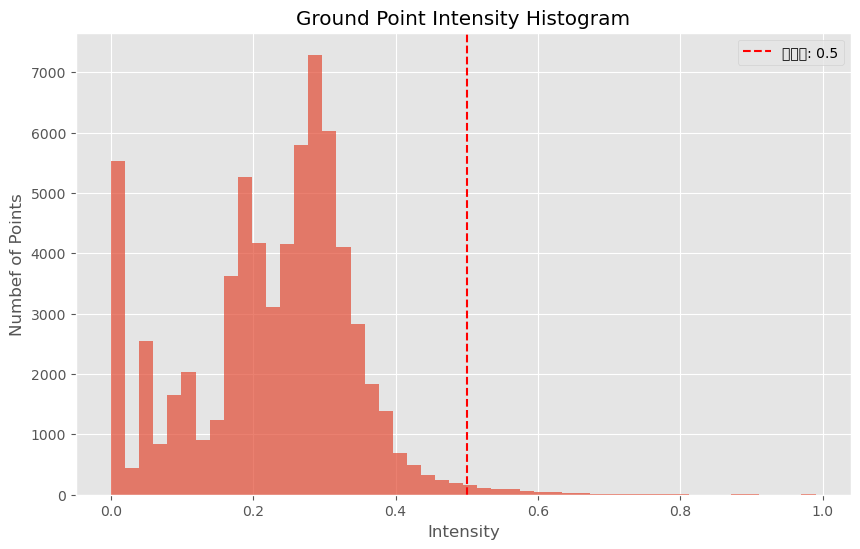

In [15]:
# 강도 임계값 설정
intensity_threshold = 0.5  # 강도 임계값 (0.0 ~ 1.0)

# 높은 강도를 가진 지면 포인트 필터링
high_intensity_mask = ground_points[:, 3] > intensity_threshold
high_intensity_points = ground_points[high_intensity_mask]

print(f"높은 강도를 가진 지면 포인트 개수: {high_intensity_points.shape[0]}")
print(f"비율: {high_intensity_points.shape[0] / ground_points.shape[0] * 100:.2f}%")

# 높은 강도 포인트 시각화
plt.figure(figsize=(12, 12))
plt.scatter(high_intensity_points[:, 0], high_intensity_points[:, 1], c='r', s=2.0)
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Ground Points with High Intensity (Lane Candidate)')
plt.grid(True)
plt.axis('equal')
plt.show()

# 강도 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(ground_points[:, 3], bins=50, alpha=0.7)
plt.axvline(x=intensity_threshold, color='r', linestyle='--', label=f'임계값: {intensity_threshold}')
plt.xlabel('Intensity')
plt.ylabel('Numbef of Points')
plt.title('Ground Point Intensity Histogram')
plt.legend()
plt.grid(True)
plt.show()

## 6. 그리드 기반 누적 히스토그램

지면을 격자로 나누어 각 격자 셀의 평균 강도를 계산하고, 이를 이미지로 변환하여 차선 검출에 활용합니다.


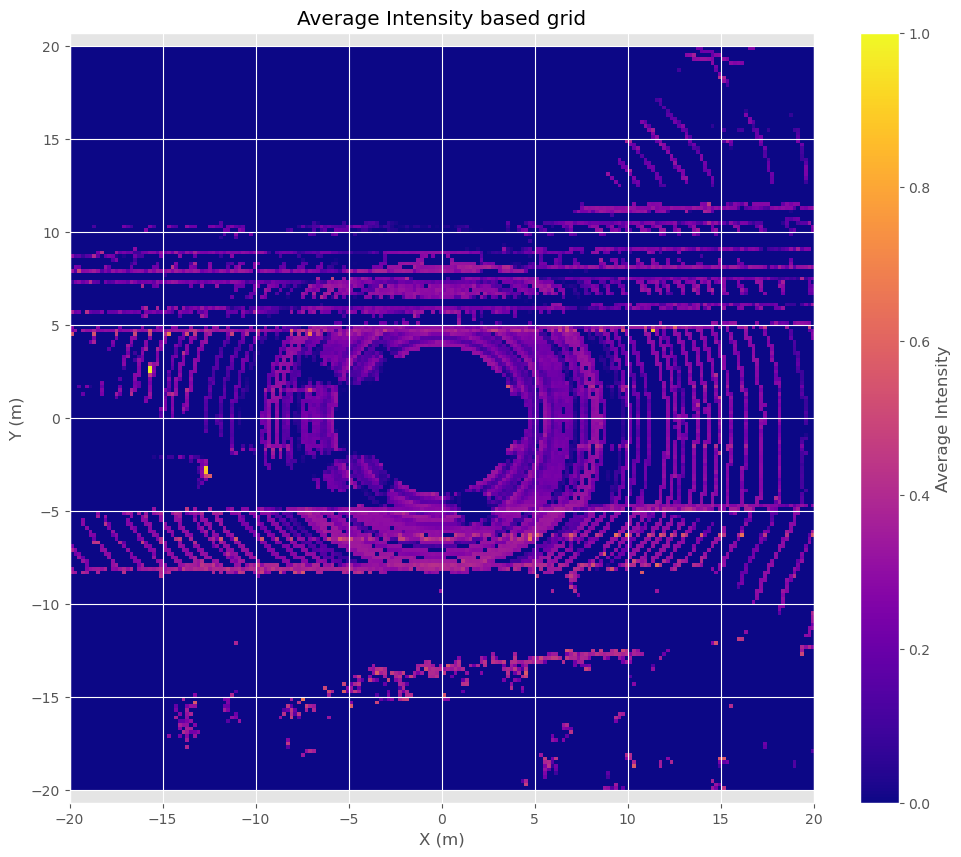

In [8]:
# 그리드 파라미터 설정
grid_size = 0.2  # 격자 크기 (m)
x_range = (-20, 20)  # X 범위
y_range = (-20, 20)  # Y 범위

# 그리드 차원 계산
x_bins = int((x_range[1] - x_range[0]) / grid_size)
y_bins = int((y_range[1] - y_range[0]) / grid_size)

# 초기화
intensity_grid = np.zeros((y_bins, x_bins))
count_grid = np.zeros((y_bins, x_bins))

# 포인트를 그리드에 누적
for point in ground_points:
    x, y, z, intensity = point
    
    # 범위 밖 포인트 무시
    if x < x_range[0] or x >= x_range[1] or y < y_range[0] or y >= y_range[1]:
        continue
        
    # 그리드 인덱스 계산
    x_idx = int((x - x_range[0]) / grid_size)
    y_idx = int((y - y_range[0]) / grid_size)
    
    # 각 셀에 강도값 누적
    intensity_grid[y_idx, x_idx] += intensity
    count_grid[y_idx, x_idx] += 1

# 평균 강도 계산 (0으로 나누기 방지)
with np.errstate(divide='ignore', invalid='ignore'):
    avg_intensity_grid = np.divide(intensity_grid, count_grid)
    avg_intensity_grid = np.nan_to_num(avg_intensity_grid)  # NaN을 0으로 변환

# 강도 그리드 시각화
plt.figure(figsize=(12, 10))
plt.imshow(avg_intensity_grid, origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]], 
           cmap='plasma', vmin=0, vmax=1)
plt.colorbar(label='Average Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Average Intensity based grid')
plt.axis('equal')
plt.grid(True)
plt.show()

## 7. 이미지 처리를 통한 차선 검출

누적 강도 그리드를 이미지로 변환하고, 이미지 처리 기법을 적용하여 차선을 검출합니다.

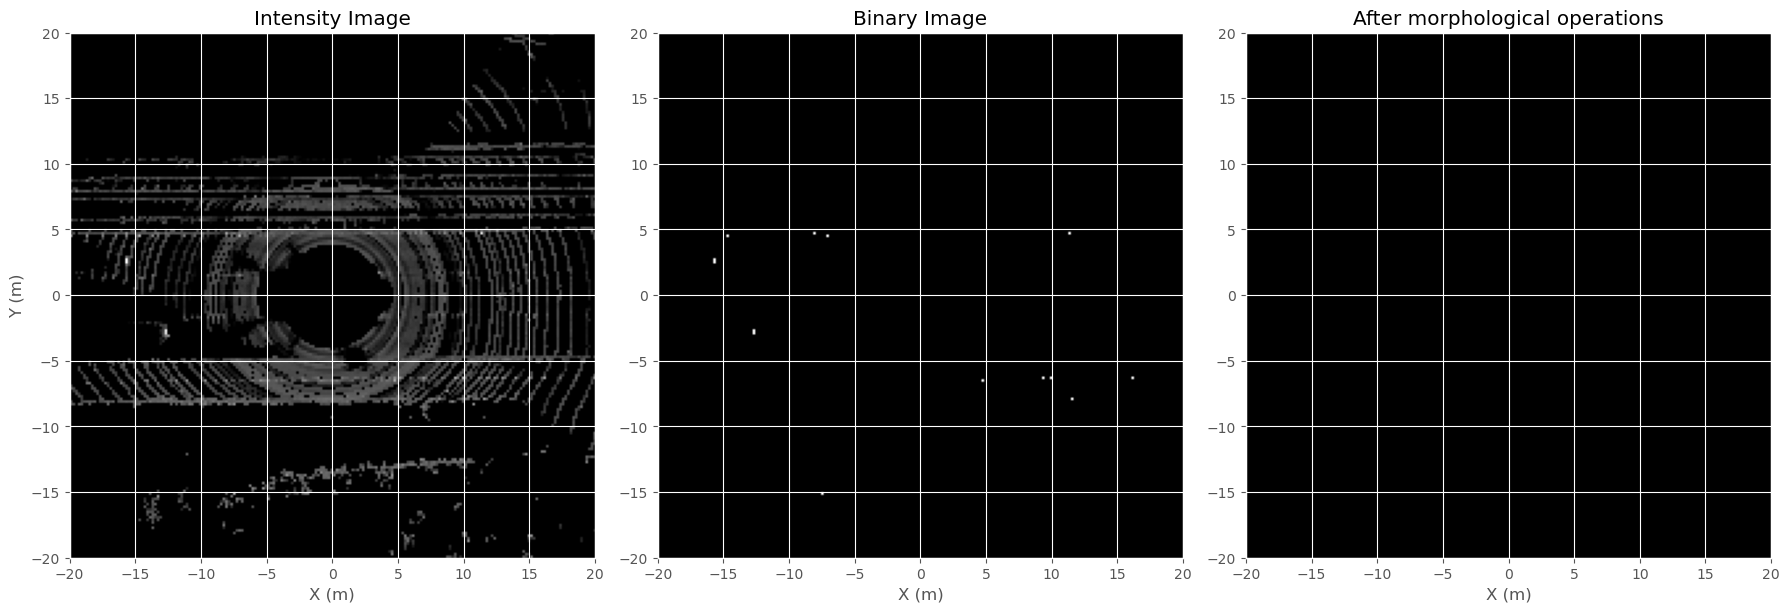

In [9]:
# 이미지 전처리
# 1. 강도 이미지 정규화
intensity_img = avg_intensity_grid.copy()
intensity_img = (intensity_img * 255).astype(np.uint8)

# 2. 임계값 적용
threshold = 150
_, binary_img = cv2.threshold(intensity_img, threshold, 255, cv2.THRESH_BINARY)

# 3. 노이즈 제거를 위한 형태학적 연산
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# 전처리 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(intensity_img, cmap='gray', origin='lower', 
               extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
axes[0].set_title('Intensity Image')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].grid(True)

axes[1].imshow(binary_img, cmap='gray', origin='lower', 
               extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
axes[1].set_title('Binary Image')
axes[1].set_xlabel('X (m)')
axes[1].grid(True)

axes[2].imshow(closing, cmap='gray', origin='lower', 
               extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
axes[2].set_title('After morphological operations')
axes[2].set_xlabel('X (m)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 8. 허프 변환을 통한 직선 검출

이진화된 이미지에 허프 변환을 적용하여 직선 형태의 차선을 검출합니다.

/home/shbyun/miniconda3/envs/lidar-perception/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shbyun/miniconda3/envs/lidar-perception/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shbyun/miniconda3/envs/lidar-perception/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


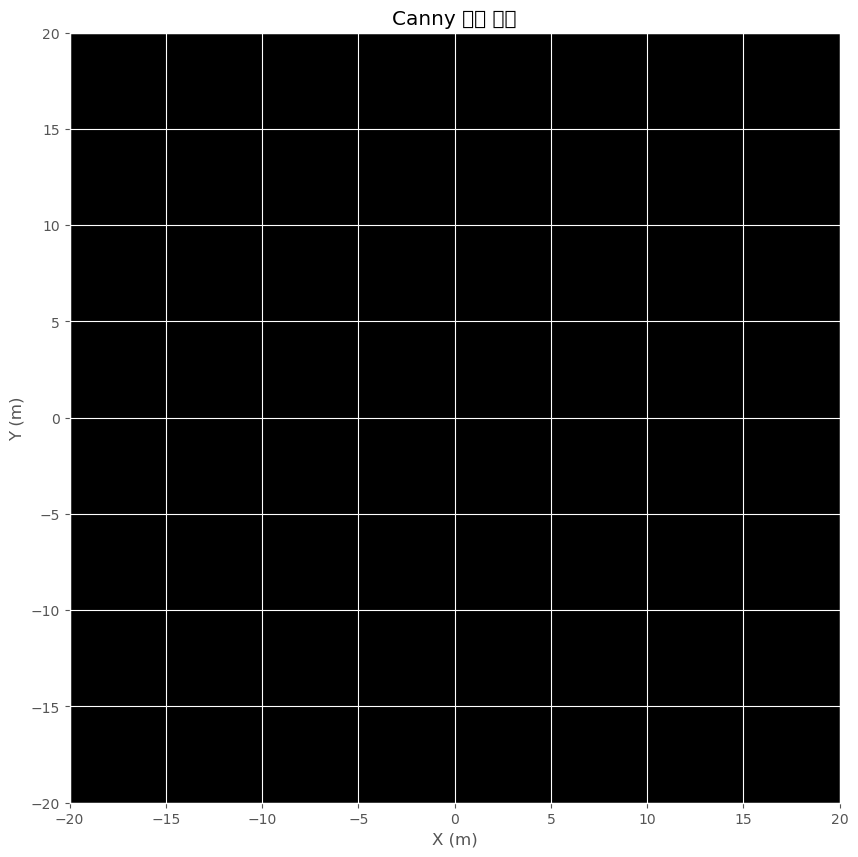

/tmp/ipykernel_24886/1374949045.py:60: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/1374949045.py:60: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/1374949045.py:60: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/1374949045.py:60: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/1374949045.py:60: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/1374949045.py:60: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/1374949045.py:60: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24886/1374949045.py:60:

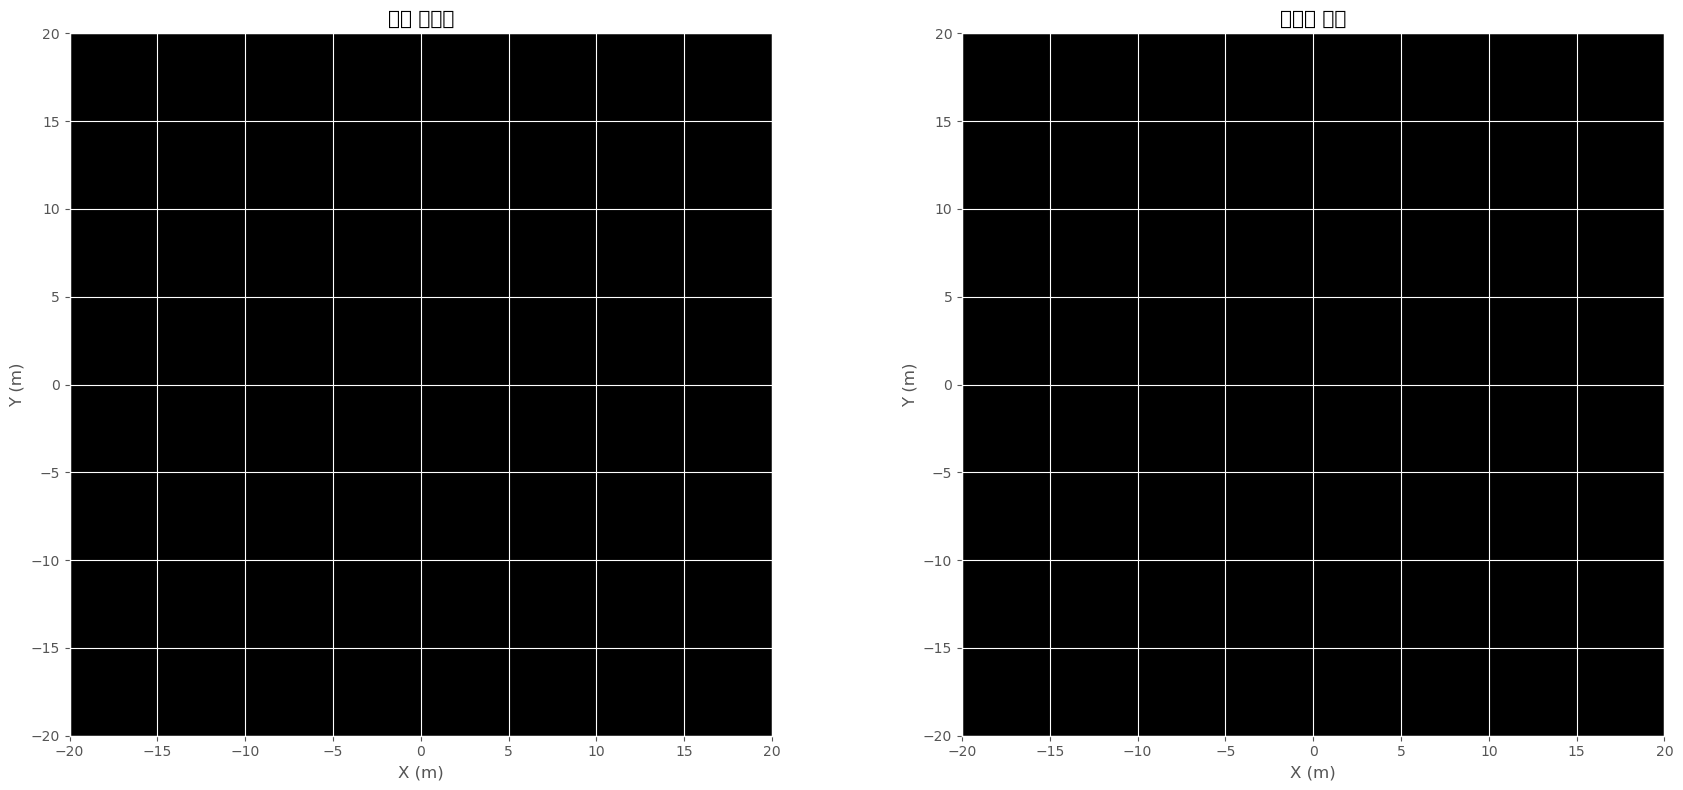

In [10]:
# Canny 에지 검출 적용
edges = cv2.Canny(closing, 50, 150)

# 에지 이미지 시각화
plt.figure(figsize=(12, 10))
plt.imshow(edges, cmap='gray', origin='lower', 
           extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
plt.title('Canny 에지 검출')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid(True)
plt.show()

# 허프 변환을 사용한 직선 검출
lines = cv2.HoughLinesP(
    edges, rho=1, theta=np.pi/180, threshold=20, 
    minLineLength=10, maxLineGap=5
)

# 원본 이미지에 검출된 직선 표시
line_img = np.zeros((y_bins, x_bins, 3), dtype=np.uint8)

# 검출된 직선이 있는 경우
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # 그리드 인덱스를 실제 좌표로 변환
        x1_m = x_range[0] + x1 * grid_size
        y1_m = y_range[0] + y1 * grid_size
        x2_m = x_range[0] + x2 * grid_size
        y2_m = y_range[0] + y2 * grid_size
        
        # 직선 파라미터 출력
        distance = np.sqrt((x2_m - x1_m)**2 + (y2_m - y1_m)**2)
        angle = np.arctan2(y2_m - y1_m, x2_m - x1_m) * 180 / np.pi
        print(f"직선: 시작=({x1_m:.2f}, {y1_m:.2f}), 끝=({x2_m:.2f}, {y2_m:.2f}), 길이={distance:.2f}m, 각도={angle:.2f}°")
        
        # 이미지에 직선 그리기
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 에지 이미지
axes[0].imshow(edges, cmap='gray', origin='lower', 
               extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
axes[0].set_title('에지 이미지')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].grid(True)

# 검출된 직선이 표시된 이미지
axes[1].imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB), origin='lower', 
               extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
axes[1].set_title('검출된 직선')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 9. 검출된 선을 3D 포인트로 변환

2D 그리드에서 검출된 차선을 실제 3D 공간의 포인트로 변환합니다.

In [11]:
# 검출된 직선이 있는 경우
if lines is not None:
    # 검출된 모든 직선에 대한 3D 포인트 생성
    lane_points_3d = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # 그리드 인덱스를 실제 좌표로 변환
        x1_m = x_range[0] + x1 * grid_size
        y1_m = y_range[0] + y1 * grid_size
        x2_m = x_range[0] + x2 * grid_size
        y2_m = y_range[0] + y2 * grid_size
        
        # 직선을 따라 n개의 포인트 샘플링
        n_points = 50
        x_points = np.linspace(x1_m, x2_m, n_points)
        y_points = np.linspace(y1_m, y2_m, n_points)
        
        # 평면 방정식을 사용하여 z 좌표 계산
        # ax + by + cz + d = 0 => z = -(ax + by + d) / c
        z_points = -(normal[0] * x_points + normal[1] * y_points + intercept) / normal[2]
        
        # 3D 포인트로 변환
        for i in range(n_points):
            lane_points_3d.append([x_points[i], y_points[i], z_points[i]])
    
    # numpy 배열로 변환
    lane_points_3d = np.array(lane_points_3d)
    
    # 3D 시각화
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 지면 포인트 (샘플링)
    sample_idx = np.random.choice(ground_points.shape[0], 5000, replace=False)
    ax.scatter(ground_points[sample_idx, 0], ground_points[sample_idx, 1], ground_points[sample_idx, 2], 
               c='gray', s=0.5, alpha=0.3, label='지면')
    
    # 차선 포인트
    ax.scatter(lane_points_3d[:, 0], lane_points_3d[:, 1], lane_points_3d[:, 2], 
               c='r', s=5.0, label='검출된 차선')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('3D 공간에 투영된 차선')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 조감도에도 표시
    plt.figure(figsize=(12, 10))
    plt.scatter(ground_points[:, 0], ground_points[:, 1], c=ground_points[:, 3], 
               cmap='plasma', s=1.0, alpha=0.5)
    plt.scatter(lane_points_3d[:, 0], lane_points_3d[:, 1], c='r', s=5.0, label='검출된 차선')
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('검출된 차선 (조감도)')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()
else:
    print("검출된 직선이 없습니다.")

검출된 직선이 없습니다.


## 10. RANSAC을 이용한 차선 모델링

검출된 차선 포인트를 다항식으로 피팅하여 곡선 차선을 모델링합니다.

In [12]:
# 검출된 직선이 있고, 충분한 수의 차선 포인트가 있는 경우
if lines is not None and len(lane_points_3d) > 0:
    # 검출된 직선을 왼쪽/오른쪽 차선으로 분류
    # y 좌표가 음수이면 왼쪽, 양수이면 오른쪽으로 단순 분류
    left_lane_points = lane_points_3d[lane_points_3d[:, 1] < 0]
    right_lane_points = lane_points_3d[lane_points_3d[:, 1] >= 0]
    
    print(f"왼쪽 차선 포인트 수: {len(left_lane_points)}")
    print(f"오른쪽 차선 포인트 수: {len(right_lane_points)}")
    
    # 다항식 차수 설정
    poly_degree = 2  # 2차 다항식 (곡선 차선)
    
    # 왼쪽/오른쪽 차선 모델링 함수
    def fit_lane_model(lane_points, degree=2):
        """
        차선 포인트를 다항식으로 피팅
        
        Args:
            lane_points (numpy.ndarray): 차선 포인트 [N, 3]
            degree (int): 다항식 차수
        
        Returns:
            tuple: (계수, 다항식 함수, x 범위)
        """
        if len(lane_points) < degree + 1:
            print("포인트가 충분하지 않습니다.")
            return None, None, None
        
        # x, y 좌표 추출
        x = lane_points[:, 0]
        y = lane_points[:, 1]
        
        # RANSAC을 이용한 다항식 피팅
        model = make_pipeline(PolynomialFeatures(degree), RANSACRegressor(
            min_samples=degree+1, residual_threshold=0.5, max_trials=100))
        
        try:
            model.fit(x.reshape(-1, 1), y)
            ransac = model.named_steps['ransacregressor']
            inlier_mask = ransac.inlier_mask_
            
            # 계수 추출 (LinearRegression 모델 사용)
            poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            poly.fit(x[inlier_mask].reshape(-1, 1), y[inlier_mask])
            
            # 다항식 함수 생성
            def poly_func(x_new):
                return poly.predict(x_new.reshape(-1, 1))
            
            # x 범위 (min, max)
            x_range = (np.min(x), np.max(x))
            
            return poly.named_steps['linearregression'].coef_, poly_func, x_range
        except:
            print("모델 피팅 실패")
            return None, None, None
    
    # 왼쪽/오른쪽 차선 모델 피팅
    left_coeffs, left_func, left_x_range = fit_lane_model(left_lane_points, poly_degree)
    right_coeffs, right_func, right_x_range = fit_lane_model(right_lane_points, poly_degree)
    
    # 피팅된 차선 시각화
    plt.figure(figsize=(12, 10))
    
    # 지면 포인트 (강도)
    plt.scatter(ground_points[:, 0], ground_points[:, 1], c=ground_points[:, 3], 
               cmap='plasma', s=1.0, alpha=0.3)
    
    # 검출된 차선 포인트
    if len(left_lane_points) > 0:
        plt.scatter(left_lane_points[:, 0], left_lane_points[:, 1], c='r', s=5.0, label='왼쪽 차선 포인트')
    if len(right_lane_points) > 0:
        plt.scatter(right_lane_points[:, 0], right_lane_points[:, 1], c='b', s=5.0, label='오른쪽 차선 포인트')
    
    # 피팅된 차선 모델
    if left_func is not None:
        x_left = np.linspace(left_x_range[0], left_x_range[1], 100)
        y_left = left_func(x_left)
        plt.plot(x_left, y_left, 'r-', linewidth=3, label='왼쪽 차선 모델')
    
    if right_func is not None:
        x_right = np.linspace(right_x_range[0], right_x_range[1], 100)
        y_right = right_func(x_right)
        plt.plot(x_right, y_right, 'b-', linewidth=3, label='오른쪽 차선 모델')
    
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('피팅된 차선 모델')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()
    
    # 모델 파라미터 출력
    if left_coeffs is not None:
        print("왼쪽 차선 모델 (다항식 계수):")
        # 계수 포맷팅 (상수항부터 고차항까지)
        for i, coef in enumerate(left_coeffs):
            if i == 0:
                print(f"  상수항: {coef}")
            else:
                print(f"  {i}차항: {coef}")
    
    if right_coeffs is not None:
        print("\n오른쪽 차선 모델 (다항식 계수):")
        # 계수 포맷팅 (상수항부터 고차항까지)
        for i, coef in enumerate(right_coeffs):
            if i == 0:
                print(f"  상수항: {coef}")
            else:
                print(f"  {i}차항: {coef}")
else:
    print("검출된 차선 포인트가 없습니다.")


검출된 차선 포인트가 없습니다.


## 11. 주행 가능 영역 추정

검출된 차선을 기반으로 주행 가능 영역을 추정하고 시각화합니다.

In [16]:
# 검출된 차선 모델을 기반으로 주행 가능 영역 계산
if left_func is not None and right_func is not None:
    # x 범위 계산 (두 차선의 공통 범위)
    x_min = max(left_x_range[0], right_x_range[0])
    x_max = min(left_x_range[1], right_x_range[1])
    
    if x_min < x_max:  # 유효한 범위가 있는 경우
        x_points = np.linspace(x_min, x_max, 100)
        left_y = left_func(x_points)
        right_y = right_func(x_points)
        
        # 주행 가능 영역 시각화
        plt.figure(figsize=(12, 10))
        
        # 지면 포인트 (강도)
        plt.scatter(ground_points[:, 0], ground_points[:, 1], c=ground_points[:, 3], 
                   cmap='plasma', s=1.0, alpha=0.3)
        
        # 피팅된 차선 모델
        plt.plot(x_points, left_y, 'r-', linewidth=3, label='왼쪽 차선')
        plt.plot(x_points, right_y, 'b-', linewidth=3, label='오른쪽 차선')
        
        # 주행 가능 영역
        plt.fill_between(x_points, left_y, right_y, color='g', alpha=0.3, label='주행 가능 영역')
        
        plt.xlim(x_range)
        plt.ylim(y_range)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('주행 가능 영역')
        plt.grid(True)
        plt.axis('equal')
        plt.legend()
        plt.show()
        
        # 차선 간 거리 계산
        lane_distances = right_y - left_y
        avg_lane_width = np.mean(lane_distances)
        
        print(f"평균 차선 간 거리: {avg_lane_width:.2f} m")
        print(f"최소 차선 간 거리: {np.min(lane_distances):.2f} m")
        print(f"최대 차선 간 거리: {np.max(lane_distances):.2f} m")
        
        # 차선 간 거리 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(x_points, lane_distances, 'g-', linewidth=2)
        plt.axhline(y=avg_lane_width, color='r', linestyle='--', label=f'평균: {avg_lane_width:.2f} m')
        plt.xlabel('X (m)')
        plt.ylabel('차선 간 거리 (m)')
        plt.title('차선 간 거리')
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("두 차선의 공통 x 범위가 없습니다.")
elif left_func is not None or right_func is not None:
    print("한쪽 차선만 검출되었습니다. 주행 가능 영역을 계산할 수 없습니다.")
else:
    print("검출된 차선이 없습니다. 주행 가능 영역을 계산할 수 없습니다.")

NameError: name 'left_func' is not defined

## 12. 요약 및 결론

이 노트북에서는 LiDAR 포인트 클라우드에서 차선을 검출하는 방법을 살펴보았습니다:

1. **지면 검출 및 추출**: RANSAC을 이용하여 지면을 검출하고 추출했습니다.
2. **강도 기반 필터링**: 높은 반사율을 가진 포인트를 필터링하여 차선 후보를 추출했습니다.
3. **그리드 기반 누적**: 지면을 격자로 나누어 각 셀의 평균 강도를 계산했습니다.
4. **이미지 처리**: 강도 그리드를 이미지로 변환하고 전처리 후 에지를 검출했습니다.
5. **허프 변환**: 에지 이미지에서 직선 성분을 검출했습니다.
6. **3D 변환**: 검출된 2D 선을 3D 공간으로 변환했습니다.
7. **다항식 피팅**: 검출된 차선 포인트를 다항식으로 모델링했습니다.
8. **주행 가능 영역 추정**: 검출된 차선을 기반으로 주행 가능 영역을 시각화했습니다.

이러한 방법은 자율주행차의 차선 인식 및 경로 계획에 활용될 수 있습니다.

## 개선 방향

- 다양한 도로 조건(그림자, 비, 눈 등)에서의 강인성 향상
- 시간적 필터링을 통한 차선 추적
- 도로 표시(정지선, 화살표 등) 인식 추가
- 카메라 영상과의 융합을 통한 정확도 향상